In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pandas.plotting import table

%matplotlib inline

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

In [ ]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

## What am I going to do?

Основываясь на статистических данных, попробовать выяснить какой тип розыграша (для начала) выгоднее играть в той или иной ситуации в американском футболе.

## Gathering Data

In [2]:
pd.options.display.max_columns = None #have to see all 

df = pd.read_csv('data/NFL Play by Play 2009-2018 (v5).csv', low_memory=False)
print('Размер выборки: ', df.shape)
df.head()

Размер выборки:  (449371, 255)


,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,receiver_player_id,receiver_player_name,rusher_player_id,rusher_player_name,lateral_receiver_player_id,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackl

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449371 entries, 0 to 449370
Columns: 255 entries, play_id to defensive_extra_point_conv
dtypes: float64(135), int64(18), object(102)
memory usage: 874.2+ MB


In [4]:
for col in df.columns: 
    print(col) 

play_id
game_id
home_team
away_team
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa
total_away_rush_epa
total_home_pass_epa
total_away_pass_e

In [5]:
first_clean = [
    'play_id','game_id','posteam','posteam_type','defteam','yardline_100','half_seconds_remaining','game_seconds_remaining','game_date','drive','qtr','down','yrdln','ydstogo',
    'play_type','yards_gained','shotgun','no_huddle','qb_scramble','pass_length','pass_location','air_yards','yards_after_catch','run_location','run_gap',
    'posteam_timeouts_remaining','defteam_timeouts_remaining','posteam_score','defteam_score','score_differential','first_down_rush','first_down_pass','first_down_penalty',
    'third_down_converted','fourth_down_converted','incomplete_pass','interception','safety','penalty','rush_attempt','pass_attempt','sack','touchdown','pass_touchdown','fumble',
    'complete_pass','ydsnet','desc'
               ]

# ['play_id','home_team','away_team','posteam','posteam_type','defteam', 'yardline_100',
#                'half_seconds_remaining','game_seconds_remaining','drive','qtr','down','goal_to_go','game_id',
#                'time','yrdln','ydstogo','play_type','desc','yards_gained','shotgun','no_huddle','qb_scramble',
#                'pass_length','pass_location','air_yards','yards_after_catch','run_location','run_gap',
#                'two_point_conv_result','home_timeouts_remaining','away_timeouts_remaining',
#                'posteam_timeouts_remaining','away_timeouts_remaining','total_home_score','total_away_score',
#                'posteam_score','defteam_score','score_differential','first_down_rush','first_down_pass',
#                'first_down_penalty','third_down_converted','fourth_down_converted','incomplete_pass',
#                'interception','fumble_forced','fumble_not_forced','fumble_out_of_bounds','solo_tackle','safety',
#                'penalty','tackled_for_loss','fumble_lost','qb_hit','rush_attempt','pass_attempt','sack',
#                'touchdown','pass_touchdown','return_touchdown','fumble','complete_pass','assist_tackle',
#                'lateral_reception','lateral_rush','lateral_return','lateral_recovery','passer_player_id',
#                'passer_player_name','receiver_player_id','receiver_player_name','rusher_player_id',
#                'rusher_player_name','lateral_receiver_player_id','lateral_receiver_player_name',
#                'lateral_rusher_player_id','lateral_rusher_player_name','lateral_sack_player_id',
#                'lateral_sack_player_name','interception_player_id','interception_player_name',
#                'lateral_interception_player_id','lateral_interception_player_name','blocked_player_id',
#                'blocked_player_name','tackle_for_loss_1_player_id','tackle_for_loss_1_player_name',
#                'tackle_for_loss_2_player_id','tackle_for_loss_2_player_name','qb_hit_1_player_id',
#                'qb_hit_1_player_name','qb_hit_2_player_id','qb_hit_2_player_name','forced_fumble_player_1_team',
#                'forced_fumble_player_1_player_id','forced_fumble_player_1_player_name',
#                'forced_fumble_player_2_team','forced_fumble_player_2_player_id',
#                'forced_fumble_player_2_player_name','game_date']

In [6]:
df = df[first_clean]
print('Размер выборки: ', df.shape)
df.head()

Размер выборки:  (449371, 48)


,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
0,46,2009091000,PIT,home,TEN,30.0,1800.0,3600.0,2009-09-10,1,1,NaN,TEN 30,0,kickoff,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,R.Bironas kicks 67 yards from TEN 30 to PIT 3....
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,short,left,-3.0,8.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,NaN,NaN,NaN,NaN,right,end,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,deep,right,34.0,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...
4,139,2009091000,PIT,home,TEN,56.0,1707.0,3507.0,2009-09-10,1,1,4.0,PIT 44,8,punt,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(13:27) (Punt formation) D.Sepulveda punts 54 ...


In [7]:
df.to_csv('data/pbp 2009-2018 clean.csv', encoding='utf-8', index=False)

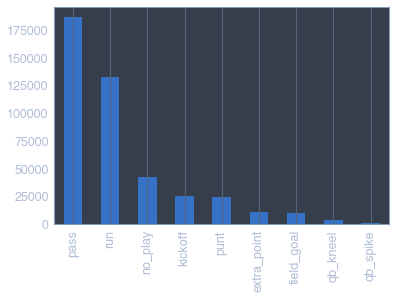

In [8]:
df['play_type'].value_counts().plot.bar(figsize=(6, 4))
plt.grid(axis='y')

In [9]:
play_type = ['run', 'pass']

df_rp = df[df.play_type.isin(play_type)]
print('Размер выборки: ', df_rp.shape)
df_rp.head()

Размер выборки:  (319369, 48)


,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,short,left,-3.0,8.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,NaN,NaN,NaN,NaN,right,end,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,deep,right,34.0,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,short,left,3.0,1.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...


In [10]:
df_rp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319369 entries, 1 to 449368
Data columns (total 48 columns):
play_id                       319369 non-null int64
game_id                       319369 non-null int64
posteam                       319369 non-null object
posteam_type                  319369 non-null object
defteam                       319369 non-null object
yardline_100                  319369 non-null float64
half_seconds_remaining        319352 non-null float64
game_seconds_remaining        319355 non-null float64
game_date                     319369 non-null object
drive                         319369 non-null int64
qtr                           319369 non-null int64
down                          318691 non-null float64
yrdln                         319369 non-null object
ydstogo                       319369 non-null int64
play_type                     319369 non-null object
yards_gained                  319159 non-null float64
shotgun                       319369 non-

In [11]:
df_rp['play_type'].value_counts(normalize=True)

pass    0.584518
run     0.415482
Name: play_type, dtype: float64

In [12]:
df_rp['rush_attempt'].value_counts(normalize=True)

0.0    0.584518
1.0    0.415482
Name: rush_attempt, dtype: float64

## Null/Nan Cleaning

In [13]:
df_rp_clean = df_rp #backup

df_rp.isnull().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining            17
game_seconds_remaining            14
game_date                          0
drive                              0
qtr                                0
down                             678
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                     210
shotgun                            0
no_huddle                          0
qb_scramble                        0
pass_length                   145506
pass_location                 145506
air_yards                     145210
yards_after_catch             210463
run_location                  188062
run_gap                       224448
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
p

### Time to end

In [14]:
df_rp[df_rp.half_seconds_remaining.isnull()]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
409271,895,2018090911,DEN,home,SEA,57.0,NaN,2800.0,2018-09-09,7,1,2.0,DEN 43,3,run,0.0,0,0,0,NaN,NaN,NaN,NaN,left,guard,3.0,3.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,41,(1:40) R.Freeman left guard to DEN 43 for no g...
411853,2595,2018091602,MIN,away,GB,57.0,NaN,NaN,2018-09-16,15,3,1.0,MIN 43,10,pass,20.0,0,0,0,deep,right,16.0,4.0,NaN,NaN,3.0,2.0,7.0,19.0,-12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,71,(1:40) K.Cousins pass deep right to A.Thielen ...
413083,2920,2018091700,CHI,home,SEA,35.0,NaN,NaN,2018-09-17,16,3,1.0,SEA 35,10,run,4.0,0,0,1,NaN,NaN,NaN,NaN,right,end,3.0,2.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66,(1:40) M.Trubisky scrambles right end to SEA 3...
415493,789,2018092311,CHI,away,ARI,75.0,NaN,2800.0,2018-09-23,6,1,1.0,CHI 25,10,run,7.0,1,0,0,NaN,NaN,NaN,NaN,left,end,3.0,3.0,0.0,14.0,-14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,26,(1:40) (Shotgun) T.Cohen left end pushed ob at...
415579,2864,2018092311,CHI,away,ARI,22.0,NaN,NaN,2018-09-23,17,3,2.0,ARI 22,7,pass,0.0,1,0,0,deep,right,22.0,NaN,NaN,NaN,2.0,3.0,10.0,14.0,-4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,21,(1:40) (Shotgun) M.Trubisky pass incomplete de...
416838,3405,2018093004,HOU,away,IND,79.0,NaN,NaN,2018-09-30,20,3,1.0,HOU 21,10,run,5.0,1,0,0,NaN,NaN,NaN,NaN,middle,NaN,2.0,3.0,27.0,17.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35,(1:40) (Shotgun) L.Miller up the middle to HOU...
417934,3257,2018093009,CLE,away,OAK,79.0,NaN,NaN,2018-09-30,22,3,3.0,CLE 21,9,pass,0.0,1,0,0,short,left,1.0,NaN,NaN,NaN,3.0,3.0,28.0,20.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,(1:40) (Shotgun) B.Mayfield pass incomplete sh...
423353,3028,2018101409,DEN,home,LA,22.0,NaN,NaN,2018-10-14,17,3,1.0,LA 22,20,pass,22.0,1,0,0,short,middle,14.0,8.0,NaN,NaN,3.0,3.0,3.0,20.0,-17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,12,(1:40) (Shotgun) C.Keenum pass short middle to...
423774,906,2018101412,NE,home,KC,45.0,NaN,2800.0,2018-10-14,7,1,1.0,KC 45,10,run,2.0,0,0,0,NaN,NaN,NaN,NaN,right,guard,3.0,3.0,10.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,75,(1:40) K.Barner right guard to KC 43 for 2 yar...
425695,740,2018102101,BAL,home,NO,50.0,NaN,2800.0,2018-10-21,2,1,2.0,MID 50,10,run,-2.0,1,1,0,NaN,NaN,NaN,NaN,right,end,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43,"(1:40) (No Huddle, Shotgun) A.Collins right en..."


In [15]:
df_rp[df_rp.game_seconds_remaining.isnull()]

##судя по всему, розыгрыши с id 1795, 610, 1541, 1632, 597, 649 были проведены в очень редком для НФЛ овертайме. Или же, у нас какая-то ошибка в заполнение. 
#Проверим игру Los Angeles Chargers c Los Angeles Rams от 2018-09-23
#Итак, это третья игровая неделя. Финальный счет 23-35, никакого овертайма

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
411853,2595,2018091602,MIN,away,GB,57.0,NaN,NaN,2018-09-16,15,3,1.0,MIN 43,10,pass,20.0,0,0,0,deep,right,16.0,4.0,NaN,NaN,3.0,2.0,7.0,19.0,-12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,71,(1:40) K.Cousins pass deep right to A.Thielen ...
413083,2920,2018091700,CHI,home,SEA,35.0,NaN,NaN,2018-09-17,16,3,1.0,SEA 35,10,run,4.0,0,0,1,NaN,NaN,NaN,NaN,right,end,3.0,2.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66,(1:40) M.Trubisky scrambles right end to SEA 3...
415188,1795,2018092310,LAC,away,LA,11.0,200.0,NaN,2018-09-23,9,2,1.0,LA 11,10,run,11.0,0,0,0,NaN,NaN,NaN,NaN,left,end,2.0,1.0,6.0,20.0,-14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,75,"(3:20) M.Gordon left end for 11 yards, TOUCHDOWN."
415579,2864,2018092311,CHI,away,ARI,22.0,NaN,NaN,2018-09-23,17,3,2.0,ARI 22,7,pass,0.0,1,0,0,deep,right,22.0,NaN,NaN,NaN,2.0,3.0,10.0,14.0,-4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,21,(1:40) (Shotgun) M.Trubisky pass incomplete de...
416838,3405,2018093004,HOU,away,IND,79.0,NaN,NaN,2018-09-30,20,3,1.0,HOU 21,10,run,5.0,1,0,0,NaN,NaN,NaN,NaN,middle,NaN,2.0,3.0,27.0,17.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35,(1:40) (Shotgun) L.Miller up the middle to HOU...
417934,3257,2018093009,CLE,away,OAK,79.0,NaN,NaN,2018-09-30,22,3,3.0,CLE 21,9,pass,0.0,1,0,0,short,left,1.0,NaN,NaN,NaN,3.0,3.0,28.0,20.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,(1:40) (Shotgun) B.Mayfield pass incomplete sh...
418065,610,2018093011,NO,away,NYG,48.0,1200.0,NaN,2018-09-30,3,1,3.0,NYG 48,1,run,2.0,0,0,0,NaN,NaN,NaN,NaN,left,end,3.0,3.0,0.0,7.0,-7.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51,(5:00) A.Kamara left end to NYG 46 for 2 yards...
418632,1541,2018100100,KC,away,DEN,66.0,200.0,NaN,2018-10-01,8,2,1.0,KC 34,23,pass,0.0,1,0,0,short,middle,11.0,NaN,NaN,NaN,2.0,3.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12,(3:20) (Shotgun) P.Mahomes pass incomplete sho...
422218,1632,2018101406,NYJ,home,IND,10.0,200.0,NaN,2018-10-14,11,2,1.0,IND 10,10,run,3.0,1,0,0,NaN,NaN,NaN,NaN,left,end,3.0,3.0,9.0,13.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,43,(3:20) (Shotgun) I.Crowell left end pushed ob ...
423353,3028,2018101409,DEN,home,LA,22.0,NaN,NaN,2018-10-14,17,3,1.0,LA 22,20,pass,22.0,1,0,0,short,middle,14.0,8.0,NaN,NaN,3.0,3.0,3.0,20.0,-17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,12,(1:40) (Shotgun) C.Keenum pass short middle to...


In [16]:
#я думаю, можно удалить строки, где у нас со временем беда
#их не так много по сравнению со всем датасетом, так что не думаю, что они сильно повлияют на конечный результат

df_rp = df_rp[pd.notnull(df_rp['half_seconds_remaining'])]
df_rp.head()

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,short,left,-3.0,8.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,NaN,NaN,NaN,NaN,right,end,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,deep,right,34.0,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,short,left,3.0,1.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...


In [17]:
df_rp = df_rp[pd.notnull(df_rp['game_seconds_remaining'])]
df_rp.head()

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,short,left,-3.0,8.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,NaN,NaN,NaN,NaN,right,end,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,deep,right,34.0,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,short,left,3.0,1.0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...


### Number of Down

In [18]:
df_rp[df_rp.down.isnull()]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
996,2996,2009091306,JAC,away,IND,2.0,667.0,667.0,2009-09-13,15,4,NaN,IND 2,0,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,12.0,14.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,58,TWO-POINT CONVERSION ATTEMPT. M.Jones-Drew rus...
1181,3721,2009091303,DEN,away,CIN,2.0,11.0,11.0,2009-09-13,21,4,NaN,CIN 2,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,12.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,87,(Pass formation) TWO-POINT CONVERSION ATTEMPT....
2383,3768,2009091312,GB,home,CHI,2.0,71.0,71.0,2009-09-13,24,4,NaN,CHI 2,0,pass,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,19.0,15.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,72,TWO-POINT CONVERSION ATTEMPT. A.Rodgers pass t...
2544,3778,2009091400,NE,home,BUF,2.0,126.0,126.0,2009-09-14,16,4,NaN,BUF 2,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,19.0,23.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,81,TWO-POINT CONVERSION ATTEMPT. T.Brady pass to ...
2549,3918,2009091400,NE,home,BUF,2.0,50.0,50.0,2009-09-14,18,4,NaN,BUF 2,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,25.0,23.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,31,TWO-POINT CONVERSION ATTEMPT. T.Brady pass to ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447224,2786,2018121603,GB,away,CHI,2.0,1150.0,1150.0,2018-12-16,13,3,NaN,CHI 2,0,pass,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,12.0,14.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,50,TWO-POINT CONVERSION ATTEMPT. A.Rodgers pass t...
447332,1020,2018121602,DET,away,BUF,15.0,645.0,2445.0,2018-12-16,4,2,NaN,BUF 15,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,75,(Kick formation) TWO-POINT CONVERSION ATTEMPT....
447502,1136,2018121601,TB,away,BAL,15.0,728.0,2528.0,2018-12-16,7,2,NaN,BAL 15,0,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,6.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,51,(Kick formation) TWO-POINT CONVERSION ATTEMPT....
447714,2332,2018121600,ATL,home,ARI,2.0,13.0,1813.0,2018-12-16,14,2,NaN,ARI 2,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,25.0,7.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,71,(Pass formation) TWO-POINT CONVERSION ATTEMPT....


In [19]:
##ага, сперва решил посмотреть на эти розыгрыши, когда нет дауна, но все же играют пас/вынос. Посмотрев на дистанцию, понял, что это двухочковые реализации после тачдауна
##это потвердило описание розыгрыша после того как я вывел его в конец таблицы, чтобы была возможность посмотреть-почитать
##остались вопросы по розыгрышам с 7,  99, 3 ярдов

df_rp[df_rp.down.isnull()]['yardline_100'].value_counts()

2.0     616
1.0      35
7.0      14
15.0     11
99.0      1
3.0       1
Name: yardline_100, dtype: int64

In [20]:
# ох, двухочковая с 99 ярдов от Нейтена Питермана (sic)
# что же это за розыгрыш такой

#в итоге просто ошибка в данных. играл он с 1 ярда 

fake_plays = df_rp[(df_rp.down.isnull()) & (df_rp.yardline_100 == 99)]
fake_plays.head(1)

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
429313,4346,2018110401,BUF,home,CHI,99.0,341.0,341.0,2018-11-04,23,4,NaN,BUF 1,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,9.0,32.0,-23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,75,TWO-POINT CONVERSION ATTEMPT. N.Peterman pass ...


In [21]:
df_rp.loc[(df_rp.posteam == 'BUF') & (df_rp.drive == 23) & (df_rp.game_date == '2018-11-04') & (df_rp.yardline_100 == 99), 'yardline_100'] = 1

In [22]:
df_rp[df_rp.down.isnull()]['yardline_100'].value_counts()

2.0     616
1.0      36
7.0      14
15.0     11
3.0       1
Name: yardline_100, dtype: int64

In [23]:
##ага, все норм теперь
fake_plays = df_rp[(df_rp.down.isnull()) & (df_rp.yardline_100 == 1)]
fake_plays.head(36)

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
10762,3571,2009100500,GB,away,MIN,1.0,220.0,220.0,2009-10-05,18,4,NaN,MIN 1,0,pass,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,19.0,30.0,-11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,96,TWO-POINT CONVERSION ATTEMPT. A.Rodgers pass t...
62780,4080,2010102500,DAL,home,NYG,1.0,197.0,197.0,2010-10-25,28,4,NaN,NYG 1,0,pass,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,25.0,38.0,-13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15,(Pass formation) TWO-POINT CONVERSION ATTEMPT....
65776,3141,2010110703,SD,away,HOU,1.0,317.0,317.0,2010-11-07,17,4,NaN,HOU 1,0,run,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,27.0,23.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,65,TWO-POINT CONVERSION ATTEMPT. M.Tolbert rushes...
69770,4262,2010111411,PIT,home,NE,1.0,179.0,179.0,2010-11-14,22,4,NaN,NE 1,0,run,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,24.0,36.0,-12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,80,TWO-POINT CONVERSION ATTEMPT. M.Moore rushes r...
82895,3740,2010121905,WAS,away,DAL,1.0,457.0,457.0,2010-12-19,19,4,NaN,DAL 1,0,pass,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,28.0,30.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,56,TWO-POINT CONVERSION ATTEMPT. R.Grossman pass ...
83076,3475,2010121910,SEA,home,ATL,1.0,509.0,509.0,2010-12-19,18,4,NaN,ATL 1,0,pass,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,16.0,33.0,-17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,88,TWO-POINT CONVERSION ATTEMPT. C.Whitehurst pas...
95804,3166,2011092505,NYG,away,PHI,1.0,487.0,487.0,2011-09-25,16,4,NaN,PHI 1,0,run,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,20.0,16.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54,(Run formation) TWO-POINT CONVERSION ATTEMPT. ...
133305,3028,2012010110,TB,away,ATL,1.0,673.0,673.0,2012-01-01,18,4,NaN,ATL 1,0,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,22.0,41.0,-19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,77,(Pass formation) TWO-POINT CONVERSION ATTEMPT....
204978,4238,2013111002,CHI,home,DET,1.0,40.0,40.0,2013-11-10,22,4,NaN,DET 1,0,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,19.0,21.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,74,#62 E. Britton reports eligible. (Run formatio...
214343,3396,2013120802,NE,home,CLE,1.0,906.0,906.0,2013-12-08,19,3,NaN,CLE 1,0,pass,2.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,9.0,19.0,-10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,72,TWO-POINT CONVERSION ATTEMPT. T.Brady pass to ...


In [24]:
df_rp.down.fillna(0, inplace=True)

In [25]:
df_rp.isna().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining             0
game_seconds_remaining             0
game_date                          0
drive                              0
qtr                                0
down                               0
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                     210
shotgun                            0
no_huddle                          0
qb_scramble                        0
pass_length                   145492
pass_location                 145492
air_yards                     145196
yards_after_catch             210446
run_location                  188053
run_gap                       224436
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
p

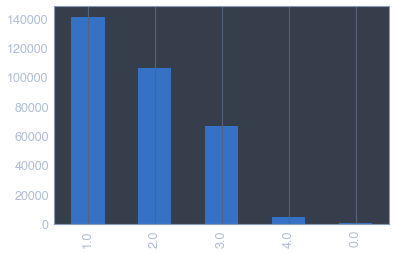

In [26]:
df_rp['down'].value_counts().plot.bar(figsize=(6, 4))
plt.grid(axis='y')

### Yards Gained

In [27]:
df_rp['yards_gained'].value_counts()

 0.0     80219
 2.0     21094
 3.0     20406
 4.0     19048
 1.0     18229
         ...  
 98.0        2
 93.0        2
-38.0        1
-26.0        1
-27.0        1
Name: yards_gained, Length: 127, dtype: int64

In [28]:
df_rp[df_rp.yards_gained.isna()]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
209596,58,2013112401,PIT,away,CLE,74.0,1795.0,3595.0,2013-11-24,1,1,1.0,PIT 26,10,pass,NaN,0,0,0,short,right,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,45,(14:55) B.Roethlisberger pass short right to E...
209597,90,2013112401,PIT,away,CLE,60.0,1770.0,3570.0,2013-11-24,1,1,1.0,PIT 40,10,run,NaN,1,1,0,NaN,NaN,NaN,NaN,left,tackle,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,"(14:30) (No Huddle, Shotgun) L.Bell left tackl..."
209598,111,2013112401,PIT,away,CLE,58.0,1733.0,3533.0,2013-11-24,1,1,2.0,PIT 42,8,run,NaN,0,1,0,NaN,NaN,NaN,NaN,right,guard,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,(13:53) (No Huddle) L.Bell right guard to CLE ...
209599,132,2013112401,PIT,away,CLE,45.0,1696.0,3496.0,2013-11-24,1,1,1.0,CLE 45,10,run,NaN,1,1,0,NaN,NaN,NaN,NaN,right,guard,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,"(13:16) (No Huddle, Shotgun) L.Bell right guar..."
209600,153,2013112401,PIT,away,CLE,43.0,1658.0,3458.0,2013-11-24,1,1,2.0,CLE 43,8,pass,NaN,1,1,0,short,middle,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,45,"(12:38) (No Huddle, Shotgun) B.Roethlisberger ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211881,4378,2013120101,JAC,away,CLE,21.0,88.0,88.0,2013-12-01,27,4,1.0,CLE 21,10,pass,NaN,1,0,0,short,left,NaN,NaN,NaN,NaN,3.0,3.0,25.0,28.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,80,(1:28) (Shotgun) C.Henne pass short left to A....
211883,4428,2013120101,JAC,away,CLE,20.0,45.0,45.0,2013-12-01,27,4,3.0,CLE 20,9,pass,NaN,1,0,0,short,left,NaN,NaN,NaN,NaN,3.0,3.0,25.0,28.0,-3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,80,(:45) (Shotgun) C.Henne pass short left to C.S...
211888,4527,2013120101,CLE,home,JAC,80.0,30.0,30.0,2013-12-01,28,4,3.0,CLE 20,10,pass,NaN,1,0,0,short,left,NaN,NaN,NaN,NaN,3.0,3.0,28.0,32.0,-4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,28,(:30) (Shotgun) B.Weeden pass short left to G....
211889,4551,2013120101,CLE,home,JAC,75.0,22.0,22.0,2013-12-01,28,4,4.0,CLE 25,5,pass,NaN,1,0,0,short,left,NaN,NaN,NaN,NaN,3.0,3.0,28.0,32.0,-4.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,28,(:22) (Shotgun) B.Weeden pass short left to D....


In [29]:
## ну тут явно косяк в заполнении, причем не хватает вообще практически все информации по розыгрышу, так что либо править вручную, либо удалять
## я выбрал удалять
df_rp = df_rp[pd.notnull(df_rp['yards_gained'])]

df_rp.isna().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining             0
game_seconds_remaining             0
game_date                          0
drive                              0
qtr                                0
down                               0
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                       0
shotgun                            0
no_huddle                          0
qb_scramble                        0
pass_length                   145376
pass_location                 145376
air_yards                     144986
yards_after_catch             210236
run_location                  187948
run_gap                       224320
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
p

### Run Plays

In [30]:
#начнем пожалуй с run_location 
df_rp['play_type'].value_counts()

pass    186564
run     132572
Name: play_type, dtype: int64

In [31]:
df_rp['run_location'].value_counts()

left      47643
right     47173
middle    36372
Name: run_location, dtype: int64

In [32]:
#так, куда делись еще ≈1400 розыгрышей
df_rp[(df_rp.run_location.isnull()) & (df_rp.play_type == 'run') & (df_rp.fumble == 1)]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
648,2653,2009091308,TB,home,DAL,72.0,1078.0,1078.0,2009-09-13,17,3,1.0,TB 28,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,7.0,20.0,-13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,9,"(2:58) B.Leftwich FUMBLES (Aborted) at TB 28, ..."
731,698,2009091305,NYJ,away,HOU,26.0,1087.0,2887.0,2009-09-13,4,1,1.0,HOU 26,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68,"(3:07) M.Sanchez FUMBLES (Aborted) at HOU 26, ..."
1056,742,2009091303,CIN,home,DEN,10.0,1011.0,2811.0,2009-09-13,4,1,4.0,DEN 10,2,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,6,(1:51) (Field Goal formation) K.Huber FUMBLES ...
1303,2833,2009091302,PHI,away,CAR,61.0,1257.0,1257.0,2009-09-13,18,3,1.0,PHI 39,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,36.0,10.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,16,"(5:57) K.Kolb FUMBLES (Aborted) at PHI 39, bal..."
2069,89,2009091310,NYG,home,WAS,75.0,1770.0,3570.0,2009-09-13,1,1,2.0,NYG 25,7,run,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,7,"(14:30) E.Manning FUMBLES (Aborted) at NYG 25,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445149,3928,2018120903,ATL,away,GB,8.0,409.0,409.0,2018-12-09,17,4,2.0,GB 8,8,run,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,14.0,33.0,-19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,53,(6:49) (Shotgun) M.Ryan Aborted. A.Mack FUMBLE...
446219,4394,2018120912,DAL,home,PHI,41.0,21.0,21.0,2018-12-09,23,4,2.0,PHI 41,6,run,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,23.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,26,(:21) (Shotgun) D.Prescott Aborted. J.Looney F...
446667,2069,2018121300,KC,home,LAC,74.0,1795.0,1795.0,2018-12-13,10,3,1.0,KC 26,10,run,-3.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,14.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,74,(14:55) (Shotgun) P.Mahomes to KC 18 for -8 ya...
447237,3110,2018121603,CHI,home,GB,23.0,863.0,863.0,2018-12-16,14,4,3.0,GB 23,1,run,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,14.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,49,(14:23) (Shotgun) Direct snap to T.Cohen. T.C...


In [33]:
#сохраню на всякий случай эти странные розыгрыши прежде чем дропать
df_shit_runs = df_rp[(df_rp.run_location.isnull()) & (df_rp.play_type == 'run')]

In [34]:
#df_rp = df_rp[pd.notnull(df_rp['run_location'])]
df_rp = df_rp[((df_rp.run_location.notnull()) & (df_rp.play_type == 'run') | (df_rp.play_type == 'pass'))]
df_rp.isna().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining             0
game_seconds_remaining             0
game_date                          0
drive                              0
qtr                                0
down                               0
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                       0
shotgun                            0
no_huddle                          0
qb_scramble                        0
pass_length                   143992
pass_location                 143992
air_yards                     143602
yards_after_catch             208852
run_location                  186564
run_gap                       222941
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
p

In [35]:
df_rp.shape

(317752, 48)

In [36]:
df_rp['run_location'].value_counts()

left      47643
right     47173
middle    36372
Name: run_location, dtype: int64

In [37]:
df_rp['run_gap'].value_counts()

end       32290
tackle    32183
guard     30338
Name: run_gap, dtype: int64

In [38]:
# не, ну так то все нормально с розыгрышами, просто нет обозначения для прохода по центру
df_rp[(df_rp.run_gap.isnull()) & (df_rp.play_type == 'run')]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...
21,542,2009091000,PIT,home,TEN,73.0,1304.0,3104.0,2009-09-10,5,1,1.0,PIT 27,10,run,1.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,(6:44) R.Mendenhall up the middle to PIT 28 fo...
22,563,2009091000,PIT,home,TEN,72.0,1269.0,3069.0,2009-09-10,5,1,2.0,PIT 28,9,run,2.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3,(6:09) R.Mendenhall up the middle to PIT 30 fo...
35,868,2009091000,TEN,away,PIT,44.0,906.0,2706.0,2009-09-10,8,1,1.0,PIT 44,10,run,1.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,(:06) C.Johnson up the middle to PIT 43 for 1 ...
54,1330,2009091000,TEN,away,PIT,73.0,427.0,2227.0,2009-09-10,10,2,2.0,TEN 27,10,run,4.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4,(7:07) L.White up the middle to TEN 31 for 4 y...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449293,2210,2018121700,NO,away,CAR,61.0,1712.0,1712.0,2018-12-17,13,3,1.0,NO 39,10,run,0.0,1,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,3.0,6.0,7.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,14,(13:32) (Shotgun) M.Ingram up the middle to NO...
449312,2723,2018121700,CAR,home,NO,73.0,1320.0,1320.0,2018-12-17,16,3,1.0,CAR 27,10,run,2.0,1,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,2.0,7.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,57,(7:00) (Shotgun) C.McCaffrey up the middle to ...
449318,2861,2018121700,CAR,home,NO,50.0,1115.0,1115.0,2018-12-17,16,3,1.0,MID 50,10,run,22.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,3.0,2.0,7.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,57,(3:35) D.Moore up the middle to NO 28 for 22 y...
449324,3052,2018121700,NO,away,CAR,54.0,955.0,955.0,2018-12-17,17,3,2.0,NO 46,1,run,1.0,0,0,0,NaN,NaN,NaN,NaN,middle,NaN,2.0,3.0,6.0,7.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,84,(:55) Z.Line up the middle to NO 47 for 1 yard...


In [39]:
# но я же люблю амфут, так что буду дотошным
# пффф, ну с восьмю розыграшами я разберусь
df_rp_anothershityruns = df_rp[(df_rp.run_gap.isnull()) & (df_rp.play_type == 'run') & (df_rp.run_location != 'middle')]
print('Размер выборки: ', df_rp_anothershityruns.shape)
df_rp_anothershityruns.head()

Размер выборки:  (8, 48)


,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
6433,3895,2009092704,MIN,home,SF,52.0,136.0,136.0,2009-09-27,25,4,1.0,MIN 48,10,run,1.0,0,0,0,NaN,NaN,NaN,NaN,right,NaN,3.0,1.0,20.0,23.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25,(2:16) B.Favre pass deep right to S.Rice pushe...
48917,79,2010091910,STL,away,OAK,73.0,1774.0,3574.0,2010-09-19,1,1,2.0,STL 27,8,run,-2.0,0,0,0,short,right,7.0,6.0,right,NaN,3.0,3.0,0.0,2.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-1,(14:34) S.Bradford pass short right to B.Bajem...
53483,1126,2010100303,DEN,away,TEN,22.0,744.0,2544.0,2010-10-03,8,2,1.0,TEN 22,10,run,17.0,0,0,0,short,left,0.0,17.0,left,NaN,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,63,(12:24) K.Orton pass short left to E.Royal to ...
98119,3719,2011100201,CLE,home,TEN,40.0,291.0,291.0,2011-10-02,22,4,2.0,TEN 40,10,run,1.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,13.0,30.0,-17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,(4:51) (Shotgun) C.McCoy pass deep left to M.M...
136275,2436,2012090910,SEA,away,ARI,75.0,1568.0,1568.0,2012-09-09,11,3,1.0,SEA 25,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,3.0,10.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,(11:08) R.Wilson pass incomplete short left to...


Пожалуй, пойдем по порядку:
<pd>
1. Игра San Francisco 49ers против Minnesota Vikings. Конец игры, осталось совсем немного времени. Минесота в нападение и у них первый даун. В таблице выносной розыгрыш и есть нарушение от Бретта Фарва. Скорей всего, он выбежал за линию скримеджа и попытался сделать пас, но давайте посмотрим записи игры
    
<МЕСТО ДЛЯ КАРТИНКИ>

  Да, все верно. Такой розыгрыш можно дропнуть

In [40]:
df_rp.drop(6433, inplace=True)

df_rp[(df_rp.run_gap.isnull()) & (df_rp.play_type == 'run') & (df_rp.run_location != 'middle')]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
48917,79,2010091910,STL,away,OAK,73.0,1774.0,3574.0,2010-09-19,1,1,2.0,STL 27,8,run,-2.0,0,0,0,short,right,7.0,6.0,right,NaN,3.0,3.0,0.0,2.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-1,(14:34) S.Bradford pass short right to B.Bajem...
53483,1126,2010100303,DEN,away,TEN,22.0,744.0,2544.0,2010-10-03,8,2,1.0,TEN 22,10,run,17.0,0,0,0,short,left,0.0,17.0,left,NaN,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,63,(12:24) K.Orton pass short left to E.Royal to ...
98119,3719,2011100201,CLE,home,TEN,40.0,291.0,291.0,2011-10-02,22,4,2.0,TEN 40,10,run,1.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,13.0,30.0,-17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,(4:51) (Shotgun) C.McCoy pass deep left to M.M...
136275,2436,2012090910,SEA,away,ARI,75.0,1568.0,1568.0,2012-09-09,11,3,1.0,SEA 25,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,3.0,10.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,(11:08) R.Wilson pass incomplete short left to...
171739,1690,2012121607,HOU,home,IND,13.0,287.0,2087.0,2012-12-16,9,2,2.0,IND 13,10,run,-4.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63,"(4:47) B.Tate left end, dead ball declared at ..."
195590,3718,2013101310,NO,away,NE,81.0,509.0,509.0,2013-10-13,20,4,1.0,NO 19,10,run,16.0,0,0,1,NaN,NaN,NaN,NaN,left,NaN,2.0,3.0,17.0,23.0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16,"(8:29) D.Brees scrambles left end, dead ball d..."
231986,3155,2014092102,CLE,home,BAL,16.0,482.0,482.0,2014-09-21,15,4,3.0,BAL 16,16,run,3.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,2.0,21.0,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61,(8:02) (Shotgun) B.Hoyer to BAL 13 for 3 yards...


In [41]:
## окей, следующий розыгрыш от Сэма Бредфорда и в описании это пас, так что изменим тип розыгрыша и удалим run_location
df_rp.loc[((df_rp.play_id == 79) & (df_rp.game_id == 2010091910)), 'play_type'] = 'pass'
df_rp.loc[((df_rp.play_id == 79) & (df_rp.game_id == 2010091910)), 'run_location'] = np.nan
df_rp.loc[((df_rp.play_id == 79) & (df_rp.game_id == 2010091910)), 'rush_attempt'] = 0

df_rp[(df_rp.play_id == 79) & (df_rp.game_id == 2010091910)]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
48917,79,2010091910,STL,away,OAK,73.0,1774.0,3574.0,2010-09-19,1,1,2.0,STL 27,8,pass,-2.0,0,0,0,short,right,7.0,6.0,NaN,NaN,3.0,3.0,0.0,2.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,-1,(14:34) S.Bradford pass short right to B.Bajem...


In [42]:
df_rp[(df_rp.run_gap.isnull()) & (df_rp.play_type == 'run') & (df_rp.run_location != 'middle')]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
53483,1126,2010100303,DEN,away,TEN,22.0,744.0,2544.0,2010-10-03,8,2,1.0,TEN 22,10,run,17.0,0,0,0,short,left,0.0,17.0,left,NaN,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,63,(12:24) K.Orton pass short left to E.Royal to ...
98119,3719,2011100201,CLE,home,TEN,40.0,291.0,291.0,2011-10-02,22,4,2.0,TEN 40,10,run,1.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,13.0,30.0,-17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,(4:51) (Shotgun) C.McCoy pass deep left to M.M...
136275,2436,2012090910,SEA,away,ARI,75.0,1568.0,1568.0,2012-09-09,11,3,1.0,SEA 25,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,3.0,10.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,(11:08) R.Wilson pass incomplete short left to...
171739,1690,2012121607,HOU,home,IND,13.0,287.0,2087.0,2012-12-16,9,2,2.0,IND 13,10,run,-4.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63,"(4:47) B.Tate left end, dead ball declared at ..."
195590,3718,2013101310,NO,away,NE,81.0,509.0,509.0,2013-10-13,20,4,1.0,NO 19,10,run,16.0,0,0,1,NaN,NaN,NaN,NaN,left,NaN,2.0,3.0,17.0,23.0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16,"(8:29) D.Brees scrambles left end, dead ball d..."
231986,3155,2014092102,CLE,home,BAL,16.0,482.0,482.0,2014-09-21,15,4,3.0,BAL 16,16,run,3.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,2.0,21.0,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61,(8:02) (Shotgun) B.Hoyer to BAL 13 for 3 yards...


In [43]:
df_rp.loc[((df_rp.play_id == 1126) & (df_rp.game_id == 2010100303)), 'play_type'] = 'pass'
df_rp.loc[((df_rp.play_id == 1126) & (df_rp.game_id == 2010100303)), 'run_location'] = np.nan
df_rp.loc[((df_rp.play_id == 1126) & (df_rp.game_id == 2010100303)), 'rush_attempt'] = 0

df_rp[(df_rp.play_id == 1126) & (df_rp.game_id == 2010100303)]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
53483,1126,2010100303,DEN,away,TEN,22.0,744.0,2544.0,2010-10-03,8,2,1.0,TEN 22,10,pass,17.0,0,0,0,short,left,0.0,17.0,NaN,NaN,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,63,(12:24) K.Orton pass short left to E.Royal to ...


In [44]:
df_rp[(df_rp.run_gap.isnull()) & (df_rp.play_type == 'run') & (df_rp.run_location != 'middle')]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
98119,3719,2011100201,CLE,home,TEN,40.0,291.0,291.0,2011-10-02,22,4,2.0,TEN 40,10,run,1.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,13.0,30.0,-17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,(4:51) (Shotgun) C.McCoy pass deep left to M.M...
136275,2436,2012090910,SEA,away,ARI,75.0,1568.0,1568.0,2012-09-09,11,3,1.0,SEA 25,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,3.0,10.0,-7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3,(11:08) R.Wilson pass incomplete short left to...
171739,1690,2012121607,HOU,home,IND,13.0,287.0,2087.0,2012-12-16,9,2,2.0,IND 13,10,run,-4.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63,"(4:47) B.Tate left end, dead ball declared at ..."
195590,3718,2013101310,NO,away,NE,81.0,509.0,509.0,2013-10-13,20,4,1.0,NO 19,10,run,16.0,0,0,1,NaN,NaN,NaN,NaN,left,NaN,2.0,3.0,17.0,23.0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16,"(8:29) D.Brees scrambles left end, dead ball d..."
231986,3155,2014092102,CLE,home,BAL,16.0,482.0,482.0,2014-09-21,15,4,3.0,BAL 16,16,run,3.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,2.0,21.0,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61,(8:02) (Shotgun) B.Hoyer to BAL 13 for 3 yards...


In [45]:
df_rp.drop(98119, inplace=True)
df_rp.drop(136275, inplace=True)

df_rp[(df_rp.run_gap.isnull()) & (df_rp.play_type == 'run') & (df_rp.run_location != 'middle')]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc
171739,1690,2012121607,HOU,home,IND,13.0,287.0,2087.0,2012-12-16,9,2,2.0,IND 13,10,run,-4.0,0,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,3.0,10.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,63,"(4:47) B.Tate left end, dead ball declared at ..."
195590,3718,2013101310,NO,away,NE,81.0,509.0,509.0,2013-10-13,20,4,1.0,NO 19,10,run,16.0,0,0,1,NaN,NaN,NaN,NaN,left,NaN,2.0,3.0,17.0,23.0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,16,"(8:29) D.Brees scrambles left end, dead ball d..."
231986,3155,2014092102,CLE,home,BAL,16.0,482.0,482.0,2014-09-21,15,4,3.0,BAL 16,16,run,3.0,1,0,0,NaN,NaN,NaN,NaN,left,NaN,3.0,2.0,21.0,17.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,61,(8:02) (Shotgun) B.Hoyer to BAL 13 for 3 yards...


In [46]:
df_rp.loc[((df_rp.play_id == 1690) & (df_rp.game_id == 2012121607)), 'run_gap'] = 'end'

In [47]:
df_rp.loc[((df_rp.play_id == 3718) & (df_rp.game_id == 2013101310)), 'run_gap'] = 'end'

In [48]:
df_rp.drop(231986, inplace=True)

In [49]:
df_rp.loc[(df_rp.run_gap.isnull()) & (df_rp.play_type == 'run') & (df_rp.run_location == 'middle'),'run_gap'] = 'center'

In [50]:
df_rp.run_gap.value_counts()

center    36369
end       32292
tackle    32183
guard     30338
Name: run_gap, dtype: int64

In [51]:
df_rp.isna().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining             0
game_seconds_remaining             0
game_date                          0
drive                              0
qtr                                0
down                               0
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                       0
shotgun                            0
no_huddle                          0
qb_scramble                        0
pass_length                   143988
pass_location                 143988
air_yards                     143598
yards_after_catch             208848
run_location                  186566
run_gap                       186566
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
p

In [52]:
# Сделали OHE для категориальных переменных
df_run_gap = pd.get_dummies(df_rp['run_gap'], prefix='run_gap')
df_run_loc = pd.get_dummies(df_rp['run_location'], prefix='run_loc')

# Объединили назад наши таблички
df_rp = pd.concat([df_rp.drop('run_gap',axis=1),df_run_gap], axis=1)
df_rp = pd.concat([df_rp.drop('run_location',axis=1),df_run_loc], axis=1)

print('Размер выборки: ', df_rp.shape)
df_rp.head()

Размер выборки:  (317748, 53)


,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc,run_gap_center,run_gap_end,run_gap_guard,run_gap_tackle,run_loc_left,run_loc_middle,run_loc_right
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,short,left,-3.0,8.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....,0,0,0,0,0,0,0
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...,0,1,0,0,0,0,1
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,deep,right,34.0,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...,0,0,0,0,0,0,0
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,NaN,NaN,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...,1,0,0,0,0,1,0
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,short,left,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...,0,0,0,0,0,0,0


In [53]:
df_rp.isna().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining             0
game_seconds_remaining             0
game_date                          0
drive                              0
qtr                                0
down                               0
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                       0
shotgun                            0
no_huddle                          0
qb_scramble                        0
pass_length                   143988
pass_location                 143988
air_yards                     143598
yards_after_catch             208848
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
posteam_score                      0
defteam_score                      0
s

### Pass Plays

In [54]:
df_rp.pass_location.value_counts()

right     70062
left      62872
middle    40826
Name: pass_location, dtype: int64

In [55]:
#категориальные данные - делаем OHE
df_pass_loc = pd.get_dummies(df_rp['pass_location'], prefix='pass_loc')

# Объединили назад наши таблички
df_rp = pd.concat([df_rp.drop('pass_location',axis=1),df_pass_loc], axis=1)

In [56]:
df_rp.pass_length.value_counts()

short    141457
deep      32303
Name: pass_length, dtype: int64

In [57]:
#категориальные данные - делаем OHE
df_pass_len = pd.get_dummies(df_rp['pass_length'], prefix='pass_len')

# Объединили назад наши таблички
df_rp = pd.concat([df_rp.drop('pass_length',axis=1),df_pass_len], axis=1)

In [58]:
df_rp.isna().sum()

play_id                            0
game_id                            0
posteam                            0
posteam_type                       0
defteam                            0
yardline_100                       0
half_seconds_remaining             0
game_seconds_remaining             0
game_date                          0
drive                              0
qtr                                0
down                               0
yrdln                              0
ydstogo                            0
play_type                          0
yards_gained                       0
shotgun                            0
no_huddle                          0
qb_scramble                        0
air_yards                     143598
yards_after_catch             208848
posteam_timeouts_remaining         0
defteam_timeouts_remaining         0
posteam_score                      0
defteam_score                      0
score_differential                 0
first_down_rush                    0
f

In [59]:
print('Размер выборки: ', df_rp.shape)
df_rp.head()

Размер выборки:  (317748, 56)


,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,air_yards,yards_after_catch,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc,run_gap_center,run_gap_end,run_gap_guard,run_gap_tackle,run_loc_left,run_loc_middle,run_loc_right,pass_loc_left,pass_loc_middle,pass_loc_right,pass_len_deep,pass_len_short
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,-3.0,8.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....,0,0,0,0,0,0,0,1,0,0,0,1
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...,0,1,0,0,0,0,1,0,0,0,0,0
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,34.0,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...,0,0,0,0,0,0,0,0,0,1,1,0
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...,1,0,0,0,0,1,0,0,0,0,0,0
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,3.0,1.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...,0,0,0,0,0,0,0,1,0,0,0,1


In [60]:
df_rp[(df_rp.air_yards.isnull()) & (df_rp.play_type == 'pass') & (df_rp.sack != 1) & (df_rp.incomplete_pass == 1)]

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,air_yards,yards_after_catch,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc,run_gap_center,run_gap_end,run_gap_guard,run_gap_tackle,run_loc_left,run_loc_middle,run_loc_right,pass_loc_left,pass_loc_middle,pass_loc_right,pass_len_deep,pass_len_short
1362,4221,2009091302,CAR,home,PHI,3.0,65.0,65.0,2009-09-13,27,4,1.0,PHI 3,3,pass,0.0,0,0,0,NaN,NaN,2.0,2.0,10.0,36.0,-26.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,50,(1:05) M.Moore pass incomplete right to K.Moore.,0,0,0,0,0,0,0,0,0,0,0,0
6847,1665,2009092706,PHI,home,KC,74.0,375.0,2175.0,2009-09-27,11,2,2.0,PHI 26,9,pass,0.0,1,0,0,NaN,NaN,1.0,3.0,21.0,7.0,14.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,14,(6:15) #7 M. Vick in at Quarterback. (Shotgu...,0,0,0,0,0,0,0,0,0,0,0,0
6865,2077,2009092706,KC,away,PHI,65.0,19.0,1819.0,2009-09-27,12,2,2.0,KC 35,1,pass,0.0,1,0,0,NaN,NaN,2.0,1.0,7.0,24.0,-17.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,(:19) (Shotgun) M.Cassel pass incomplete left ...,0,0,0,0,0,0,0,0,0,0,0,0
15681,871,2009102506,TB,home,NE,89.0,1026.0,2826.0,2009-10-25,6,1,1.0,TB 11,10,pass,0.0,0,0,0,NaN,NaN,3.0,3.0,0.0,13.0,-13.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,(2:06) J.Johnson pass incomplete middle to K.W...,0,0,0,0,0,0,0,0,0,0,0,0
16228,1651,2009102503,KC,home,SD,63.0,148.0,1948.0,2009-10-25,10,2,2.0,KC 37,6,pass,0.0,1,0,0,NaN,NaN,3.0,2.0,0.0,17.0,-17.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4,(2:28) (Shotgun) M.Cassel pass incomplete left...,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370172,3370,2017092413,OAK,away,WAS,68.0,323.0,323.0,2017-09-24,24,4,3.0,OAK 32,3,pass,0.0,1,0,0,NaN,NaN,3.0,2.0,10.0,27.0,-17.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7,(5:23) (Shotgun) D.Carr pass incomplete right.,0,0,0,0,0,0,0,0,0,0,0,0
390856,890,2017112302,NYG,away,WAS,33.0,907.0,2707.0,2017-11-23,7,1,2.0,WAS 33,7,pass,0.0,0,0,0,NaN,NaN,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,26,(:07) E.Manning pass incomplete right.,0,0,0,0,0,0,0,0,0,0,0,0
390955,3254,2017112302,WAS,home,NYG,45.0,662.0,662.0,2017-11-23,21,4,2.0,NYG 45,6,pass,0.0,0,0,0,NaN,NaN,3.0,3.0,10.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4,(11:02) K.Cousins pass incomplete right.,0,0,0,0,0,0,0,0,0,0,0,0
421917,2161,2018101408,WAS,home,CAR,69.0,1794.0,1794.0,2018-10-14,15,3,1.0,WAS 31,10,pass,0.0,0,0,0,NaN,NaN,3.0,3.0,17.0,6.0,11.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,31,(14:54) A.Smith pass incomplete right.,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
# Пожалуй эти столбцы не буду преобразовывать, а сохраню в другом датафрейме
df_wr_stats = df_rp[['air_yards','yards_after_catch']]

df_rp = df_rp.drop(['air_yards', 'yards_after_catch'], axis = 1) 

In [62]:
df_rp.isna().sum()

play_id                       0
game_id                       0
posteam                       0
posteam_type                  0
defteam                       0
yardline_100                  0
half_seconds_remaining        0
game_seconds_remaining        0
game_date                     0
drive                         0
qtr                           0
down                          0
yrdln                         0
ydstogo                       0
play_type                     0
yards_gained                  0
shotgun                       0
no_huddle                     0
qb_scramble                   0
posteam_timeouts_remaining    0
defteam_timeouts_remaining    0
posteam_score                 0
defteam_score                 0
score_differential            0
first_down_rush               0
first_down_pass               0
first_down_penalty            0
third_down_converted          0
fourth_down_converted         0
incomplete_pass               0
interception                  0
safety  

In [63]:
#df_rp = df_rp_clean

## Changing Data

### Adding season variable

In [64]:
def split_date(row):
    season = row['game_date']
    season = season[0:4]
    return season

In [65]:
import swifter

df_rp['season'] = df_rp.swifter.apply(split_date, axis = 1)

/Users/aleksandrbagdasarov/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [66]:
df_rp.head()

,play_id,game_id,posteam,posteam_type,defteam,yardline_100,half_seconds_remaining,game_seconds_remaining,game_date,drive,qtr,down,yrdln,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,fumble,complete_pass,ydsnet,desc,run_gap_center,run_gap_end,run_gap_guard,run_gap_tackle,run_loc_left,run_loc_middle,run_loc_right,pass_loc_left,pass_loc_middle,pass_loc_right,pass_len_deep,pass_len_short,season
1,68,2009091000,PIT,home,TEN,58.0,1793.0,3593.0,2009-09-10,1,1,1.0,PIT 42,10,pass,5.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,5,(14:53) B.Roethlisberger pass short left to H....,0,0,0,0,0,0,0,1,0,0,0,1,2009
2,92,2009091000,PIT,home,TEN,53.0,1756.0,3556.0,2009-09-10,1,1,2.0,PIT 47,5,run,-3.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2,(14:16) W.Parker right end to PIT 44 for -3 ya...,0,1,0,0,0,0,1,0,0,0,0,0,2009
3,113,2009091000,PIT,home,TEN,56.0,1715.0,3515.0,2009-09-10,1,1,3.0,PIT 44,8,pass,0.0,1,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2,(13:35) (Shotgun) B.Roethlisberger pass incomp...,0,0,0,0,0,0,0,0,0,1,1,0,2009
5,162,2009091000,TEN,away,PIT,98.0,1696.0,3496.0,2009-09-10,2,1,1.0,TEN 2,10,run,0.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,(13:16) C.Johnson up the middle to TEN 2 for n...,1,0,0,0,0,1,0,0,0,0,0,0,2009
6,183,2009091000,TEN,away,PIT,98.0,1660.0,3460.0,2009-09-10,2,1,2.0,TEN 2,10,pass,4.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4,(12:40) K.Collins pass short left to A.Hall to...,0,0,0,0,0,0,0,1,0,0,0,1,2009


In [67]:
#df_clean_rp = df_clean_rp.drop(['season'], axis=1)

In [68]:
df_rp.to_csv('data/pbp 2009-2018 clean.csv', encoding='utf-8', index=False)

### Adding Football Outsiders data

In [69]:
years = np.arange(2009,2019).tolist()

for year in years:
    csv_row = 'data/stats/team-defense ' + str(year) + '.csv'
    df_def = pd.read_csv(csv_row, sep = ';')
    df_def['Year'] = year
    df_def.to_csv(csv_row, index=False)

In [70]:
years = np.arange(2009,2019).tolist()

for year in years:
    csv_row = 'data/stats/team-offense ' + str(year) + '.csv'
    df_of = pd.read_csv(csv_row, sep = ';')
    df_of['Year'] = year
    df_of.to_csv(csv_row, index=False)

In [71]:
years = np.arange(2010, 2019).tolist()

df_def_origin = pd.read_csv('data/stats/team-defense 2009.csv', sep = ';')

for year in years:
    csv_row = 'data/stats/team-defense ' + str(year) + '.csv'
    df_def = pd.read_csv(csv_row, sep = ';')
    frames = [df_def_origin, df_def]
    df_def_origin = pd.concat(frames, ignore_index=True)

df_def_origin.to_csv('data/stats/team defense 2009-2018 backup.csv', encoding='utf-8', sep = ';', index=False)

df_of_origin = pd.read_csv('data/stats/team-offense 2009.csv')

for year in years:
    csv_row = 'data/stats/team-offense ' + str(year) + '.csv'
    df_of = pd.read_csv(csv_row)
    frames = [df_of_origin, df_of]
    df_of_origin = pd.concat(frames, ignore_index=False)

df_of_origin.to_csv('data/stats/team offense 2009-2018 backup.csv', encoding='utf-8', index=False)

In [83]:
df_def = pd.read_csv('data/stats/team defense 2009-2018.csv')
df_of = pd.read_csv('data/stats/team offense 2009-2018.csv')

In [81]:
#df_of.to_csv('data/stats/team offense 2009-2018.csv', index=False)
#df_def.to_csv('data/stats/team defense 2009-2018.csv', index=False)

In [84]:
df_def.head()

,TEAM,DEF. DVOA,LAST YEAR,WEIGHTED DEFENSE,WD RK,PASS DEF.,PASS RANK,RUSH DEF.,RUSH RANK,TOTAL,PASS,RUSH,VAR,VAR RK,SHED,SHED RK,Year
0,NYJ,-25.5%,14,-29.2%,1,-36.5%,1,-13.9%,7,-24.9%,-34.9%,-14.3%,14.5%,32,2.3%,8,2009
1,GB,-17.7%,12,-21.3%,2,-17.8%,4,-17.6%,2,-23.5%,-25.1%,-21.3%,11.0%,31,-7.2%,32,2009
2,PHI,-14.3%,3,-7.8%,8,-17.1%,5,-10.4%,12,-15.3%,-15.9%,-14.4%,6.5%,20,-0.2%,17,2009
3,BAL,-14.2%,2,-13.6%,5,-11.6%,7,-17.2%,5,-15.2%,-11.6%,-19.5%,6.5%,21,-0.1%,15,2009
4,SF,-14.0%,18,-16.2%,4,-11.4%,8,-17.4%,4,-15.0%,-11.8%,-19.1%,8.0%,28,-3.2%,27,2009


In [85]:
df_of.head()

,RK,TEAM,OFF. DVOA,LAST\nYEAR,WEIGHTED OFFENSE,WO RK,PASS OFF.,PASS RK,RUSH OFF.,RUSH RK,TOTAL,PASS,RUSH,VAR,VAR RK,SCHED,SHED RK,Year
0,1,NE,26.4%,7,23.3%,2,53.5%,2,6.2%,9,21.9%,46.1%,4.9%,3.0%,1,-4.3%,3,2009
1,2,NO,24.3%,4,21.2%,4,39.5%,5,14.6%,1,22.9%,38.7%,12.5%,6.7%,14,-1.1%,11,2009
2,3,DAL,21.7%,17,20.0%,5,41.9%,3,13.9%,3,19.0%,37.2%,13.6%,5.3%,9,-1.3%,10,2009
3,4,LAC,19.7%,3,26.2%,1,59.6%,1,-13.3%,31,21.3%,60.5%,-11.0%,5.6%,10,0.3%,18,2009
4,5,GB,18.8%,11,21.6%,3,31.0%,9,14.5%,2,21.5%,35.1%,15.4%,4.7%,7,3.3%,31,2009


In [90]:
# окей, приведем все команды, которые переезжали к текущим кодировкам
df_rp.defteam.value_counts()

TEN    10259
CLE    10246
KC     10161
ARI    10143
PHI    10139
NE     10126
BUF    10098
CIN    10094
MIA    10088
IND    10083
SF     10055
DEN    10022
LA      9965
NYG     9951
CHI     9928
JAX     9926
TB      9925
OAK     9907
GB      9891
BAL     9882
WAS     9847
MIN     9843
NYJ     9818
NO      9817
ATL     9791
DET     9766
CAR     9749
SEA     9748
DAL     9723
HOU     9624
LAC     9571
PIT     9562
Name: defteam, dtype: int64

In [94]:
df_of.TEAM.value_counts()

CLE    10
DEN    10
TEN    10
IND    10
PIT    10
MIN    10
DAL    10
LAC    10
ATL    10
CHI    10
CAR    10
BAL    10
ARI    10
BUF    10
CIN    10
NYG    10
TB     10
HOU    10
PHI    10
JAX    10
GB     10
DET    10
LA     10
KC     10
WAS    10
NE     10
OAK    10
SEA    10
NYJ    10
NO     10
SF     10
MIA    10
Name: TEAM, dtype: int64

In [93]:
df_def.TEAM.value_counts()

LAC    10
DEN    10
TEN    10
IND    10
CIN    10
MIN    10
DAL    10
ATL    10
CHI    10
NYJ    10
BAL    10
ARI    10
BUF    10
PIT    10
NYG    10
TB     10
HOU    10
PHI    10
JAX    10
GB     10
DET    10
LA     10
KC     10
WAS    10
NE     10
OAK    10
CLE    10
SEA    10
SF     10
NO     10
CAR    10
MIA    10
Name: TEAM, dtype: int64

In [89]:
df_rp.loc[(df_rp.defteam == 'JAC'), 'defteam'] = 'JAX'
df_rp.loc[(df_rp.defteam == 'SD'), 'defteam'] = 'LAC'
df_rp.loc[(df_rp.defteam == 'STL'), 'defteam'] = 'LA'

In [142]:
def def_dvoa(row):
    season = row['season']
    team = row['defteam']
    
    team_row = df_def.loc[(df_def.TEAM == team) & (df_def.Year == int(season))]
    index = team_row.index
    dvoa = team_row.get_value(index[0],'DEF. DVOA')
#     team_row = df_def.loc[(df_def.TEAM == team) & (df_def.Year == int(season))]
#     dvoa = team_row['DEF. DVOA']
    return dvoa

In [143]:
df_rp['DEF_DVOA'] = df_rp.swifter.apply(def_dvoa, axis =1)

In [149]:
def def_weigh(row):
    season = row['season']
    team = row['defteam']
    
    team_row = df_def.loc[(df_def.TEAM == team) & (df_def.Year == int(season))]
    index = team_row.index
    wd = team_row.get_value(index[0],'WEIGHTED DEFENSE')
#     team_row = df_def.loc[(df_def.TEAM == team) & (df_def.Year == int(season))]
#     dvoa = team_row['DEF. DVOA']
    return wd

In [151]:
df_rp['WEIGHTED_DVOA'] = df_rp.swifter.apply(def_weigh, axis =1)

/Users/aleksandrbagdasarov/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
df_rp = pd.read_csv('data/pre ready.csv')

In [68]:
pd.options.display.max_columns = None
print('Размер выборки: ', df_rp.shape)
df_rp.head()

Размер выборки:  (317748, 51)


,posteam_type,yardline_100,half_seconds_remaining,game_seconds_remaining,qtr,down,ydstogo,play_type,yards_gained,shotgun,no_huddle,qb_scramble,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,fourth_down_converted,incomplete_pass,interception,safety,penalty,sack,touchdown,fumble,complete_pass,ydsnet,run_gap_end,run_gap_guard,run_gap_tackle,run_loc_left,run_loc_middle,run_loc_right,pass_loc_left,pass_loc_middle,pass_loc_right,pass_len_deep,pass_len_short,season,def_dvoa,def_weighted,def_pass,def_rush,off_dvoa,off_weighted,off_pass,off_rush
0,0,58.0,1793.0,3593.0,1,1.0,10,1,5.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5,0,0,0,0,0,0,1,0,0,0,1,2009,0.091,0.095,0.134,0.031,0.144,0.135,0.345,-0.026
1,0,53.0,1756.0,3556.0,1,2.0,5,0,-3.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,0,0,0,0,1,0,0,0,0,0,2009,0.091,0.095,0.134,0.031,0.144,0.135,0.345,-0.026
2,0,56.0,1715.0,3515.0,1,3.0,8,1,0.0,1,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,0,0,0,0,0,1,1,0,2009,0.091,0.095,0.134,0.031,0.144,0.135,0.345,-0.026
3,1,98.0,1696.0,3496.0,1,1.0,10,0,0.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,2009,-0.046,-0.069,0.018,-0.139,0.042,0.081,0.088,0.084
4,1,98.0,1660.0,3460.0,1,2.0,10,1,4.0,0,0,0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4,0,0,0,0,0,0,1,0,0,0,1,2009,-0.046,-0.069,0.018,-0.139,0.042,0.081,0.088,0.084


In [4]:
# team_row = df_def.loc[(df_def.TEAM == 'TEN') & (df_def.Year == int('2009'))]
# index = team_row.index
# wd = team_row.get_value(index[0],'WEIGHTED DEFENSE')
# print(wd)

df_rp = df_rp.drop(['play_id'], axis=1)

## Data Visualization and Analysis

In [5]:
# Стандартные импорты plotly
import chart_studio.plotly as py
import cufflinks
cufflinks.go_offline()
# Устанавливаем глобальную тему

In [37]:
C = ['lightcoral','royalblue','forestgreen','gold','#3D0553', '#4D798C', '#7DC170', '#F7E642']

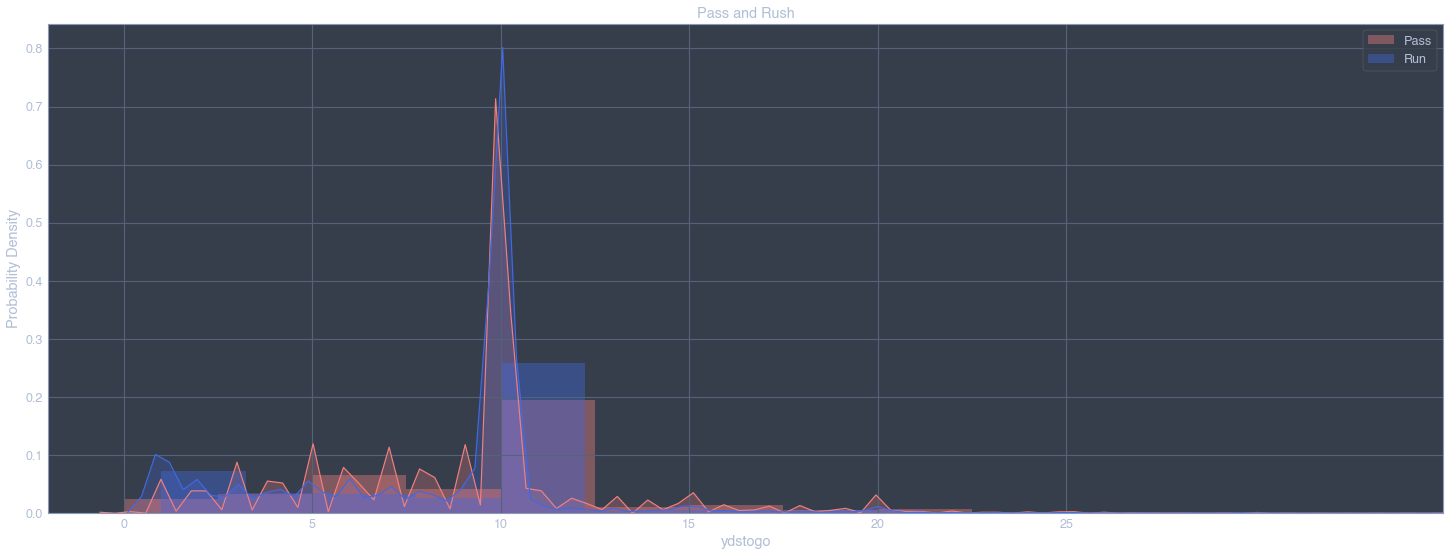

In [24]:
df_pass = df_rp[df_rp.play_type == 'pass'].copy()
df_run = df_rp[df_rp.play_type == 'run'].copy()

fig, ax = plt.subplots(figsize=(25,9))
sns.distplot(df_pass.ydstogo, bins=20, kde_kws=dict(shade=True), kde=True, color=C[0],
             ax=ax, label='Pass')
sns.distplot(df_run.ydstogo, bins=20, kde_kws=dict(shade=True), kde=True, color=C[1],
             ax=ax, label='Run')
plt.xlim(-2, 35)
plt.xticks(range(0, 30, 5))
plt.legend(loc=0)
plt.ylabel('Probability Density')
plt.title('Pass and Rush')
plt.show();

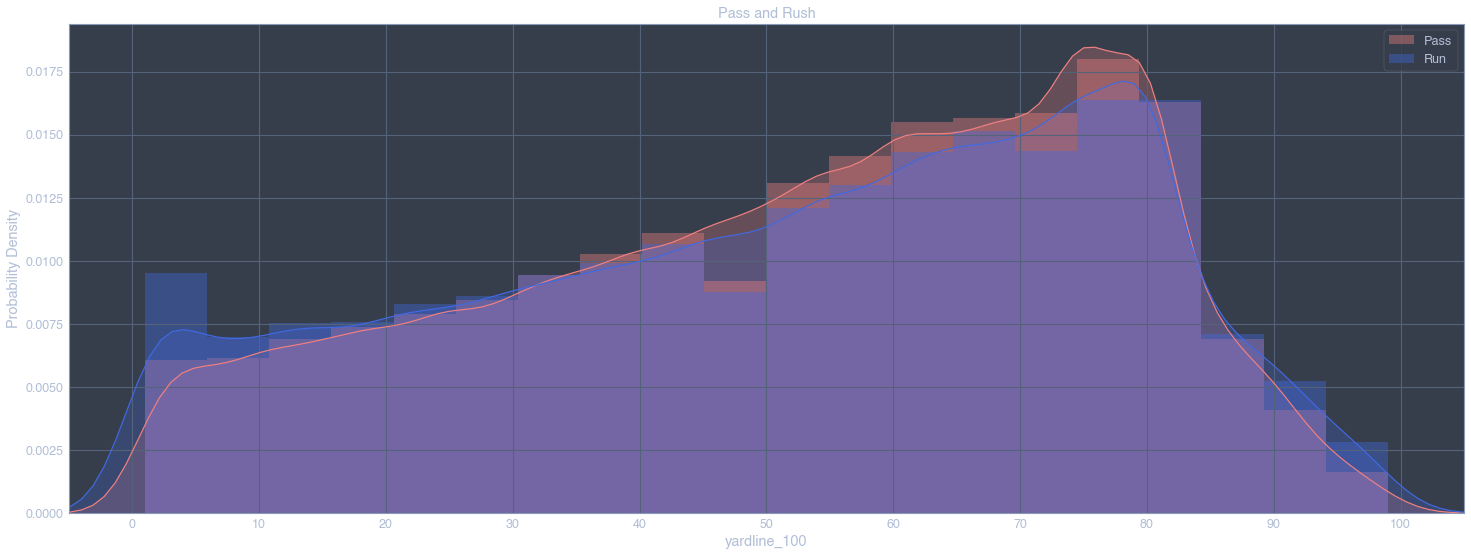

In [14]:
fig, ax = plt.subplots(figsize=(25,9))
sns.distplot(df_pass.yardline_100, bins=20, kde_kws=dict(shade=True), kde=True, color=C[0],
             ax=ax, label='Pass')
sns.distplot(df_run.yardline_100, bins=20, kde_kws=dict(shade=True), kde=True, color=C[1],
             ax=ax, label='Run')
plt.xlim(-5, 105)
plt.xticks(range(0, 101, 10))
plt.legend(loc=0)
plt.ylabel('Probability Density')
plt.title('Pass and Rush')
plt.show();

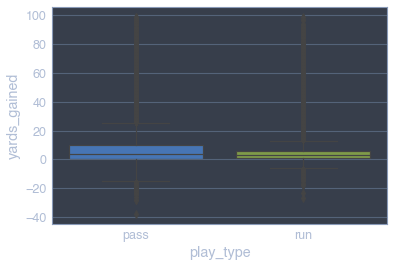

In [40]:
sns.boxplot(x="play_type", y="yards_gained", data=df_rp)

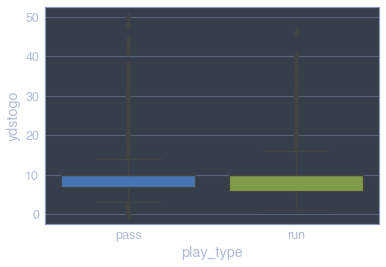

In [162]:
sns.boxplot(x="play_type", y="ydstogo", data=df_rp)

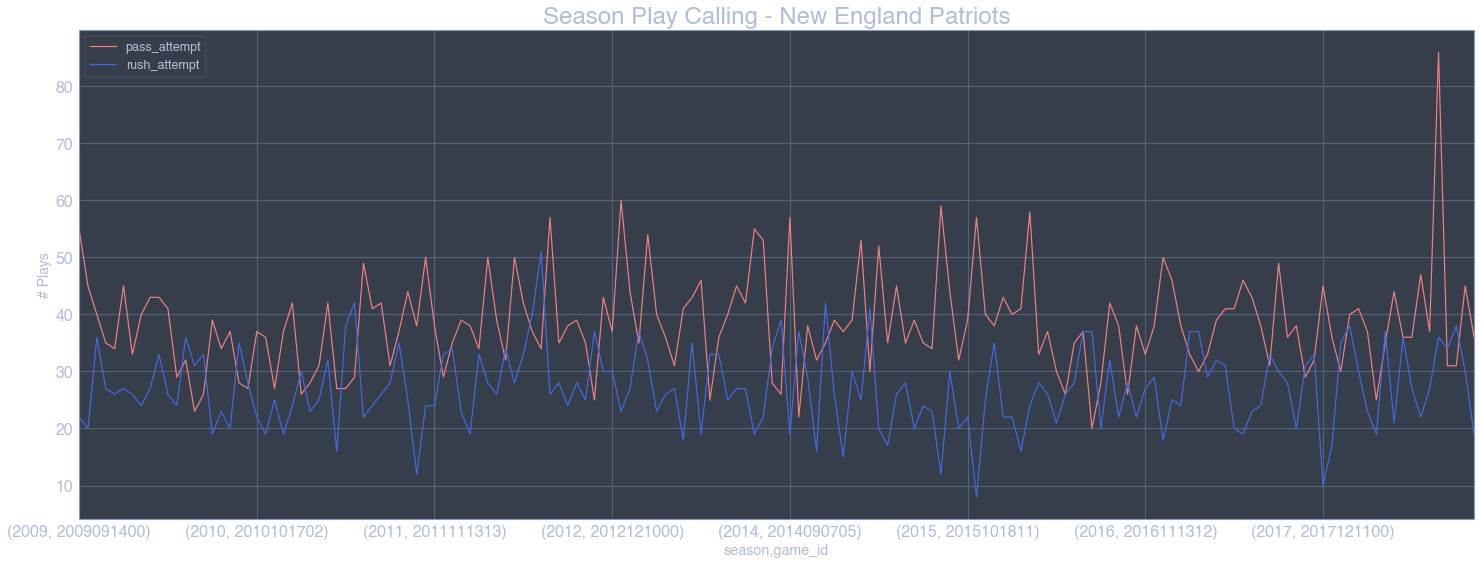

In [9]:
plays_down = df_rp[(df_rp.down <= 3) & (df_rp.qtr < 5) & (df_rp.posteam == 'NE')]
ax = plays_down.groupby(['season','game_id'])['pass_attempt','rush_attempt'].sum().plot.line(color=['lightcoral','royalblue'],figsize=(25,9),rot=0,fontsize=16)
ax.set_title("Season Play Calling - New England Patriots", fontsize=24)
ax.set_ylabel("# Plays", fontsize=14)
ax.set_alpha(0.8)

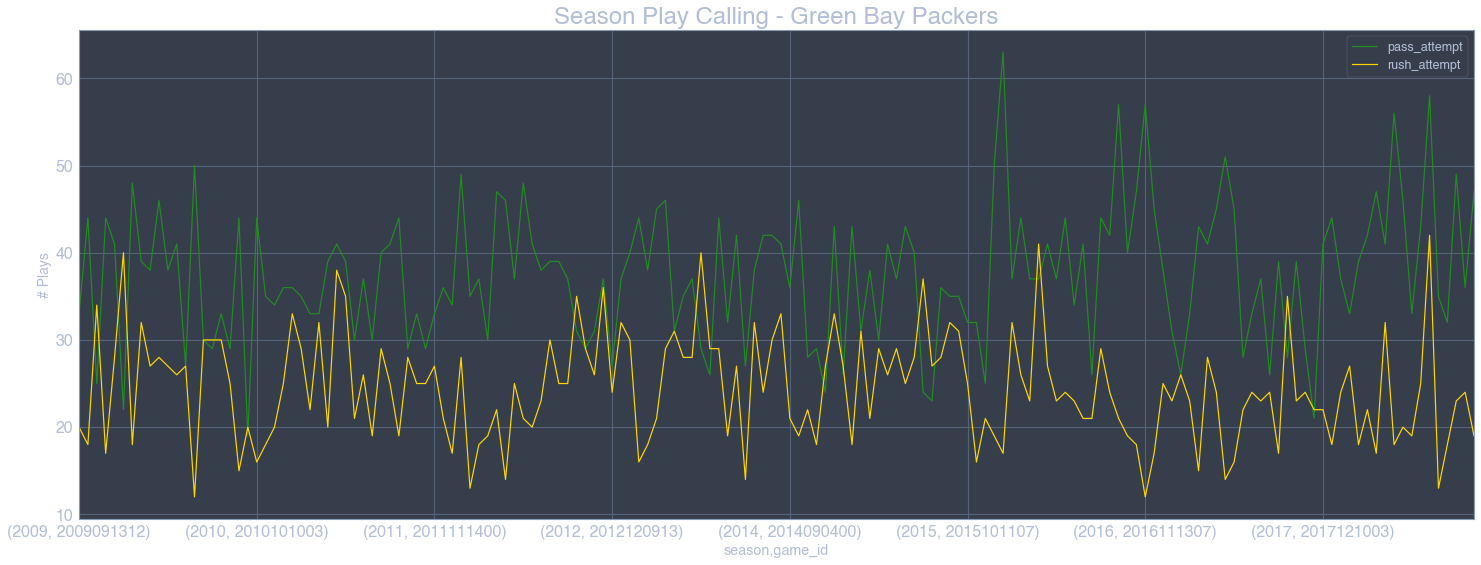

In [27]:
plays_down = df_rp[(df_rp.down <= 3) & (df_rp.qtr < 5) & (df_rp.posteam == 'GB')]
ax = plays_down.groupby(['season','game_id'])['pass_attempt','rush_attempt'].sum().plot.line(color=['forestgreen','gold'],figsize=(25,9),rot=0,fontsize=16)
ax.set_title("Season Play Calling - Green Bay Packers", fontsize=24)
ax.set_ylabel("# Plays", fontsize=14)
ax.set_alpha(0.8)

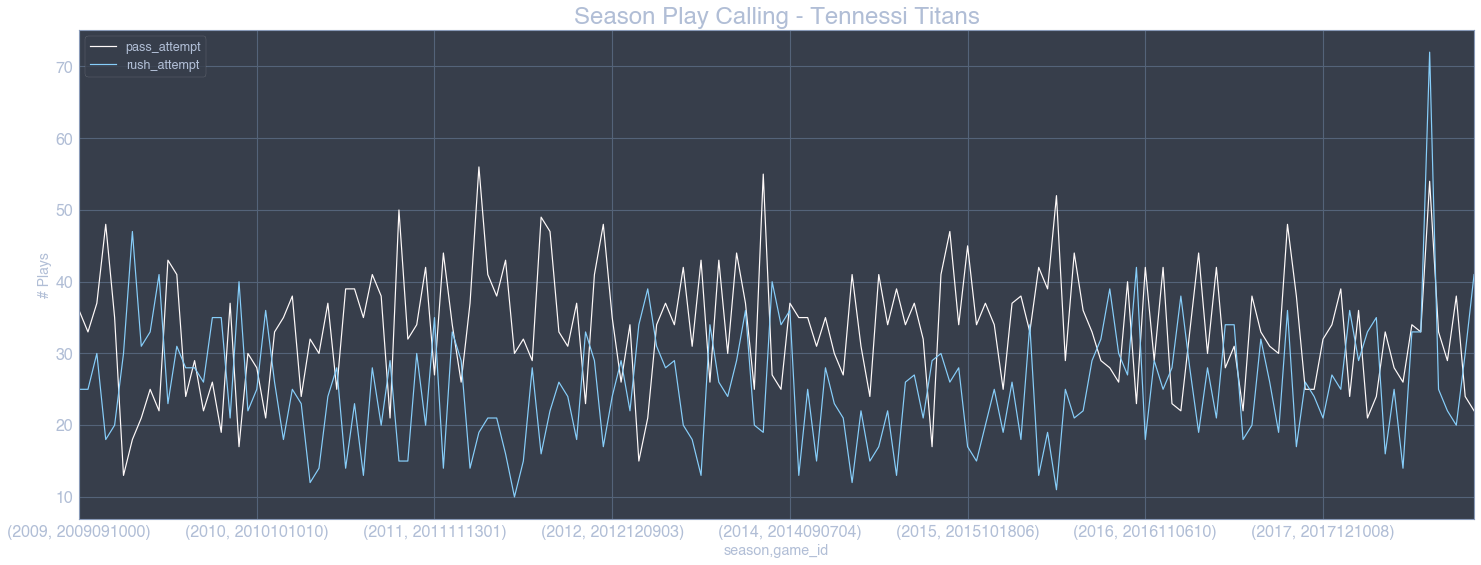

In [31]:
plays_down = df_rp[(df_rp.down <= 3) & (df_rp.qtr < 5) & (df_rp.posteam == 'TEN')]
ax = plays_down.groupby(['season','game_id'])['pass_attempt','rush_attempt'].sum().plot.line(color=['snow','lightskyblue'],figsize=(25,9),rot=0,fontsize=16)
ax.set_title("Season Play Calling - Tennessi Titans", fontsize=24)
ax.set_ylabel("# Plays", fontsize=14)
ax.set_alpha(0.8)

In [67]:
df_rp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317748 entries, 0 to 317747
Data columns (total 51 columns):
posteam_type                  317748 non-null int64
yardline_100                  317748 non-null float64
half_seconds_remaining        317748 non-null float64
game_seconds_remaining        317748 non-null float64
qtr                           317748 non-null int64
down                          317748 non-null float64
ydstogo                       317748 non-null int64
play_type                     317748 non-null int64
yards_gained                  317748 non-null float64
shotgun                       317748 non-null int64
no_huddle                     317748 non-null int64
qb_scramble                   317748 non-null int64
posteam_timeouts_remaining    317748 non-null float64
defteam_timeouts_remaining    317748 non-null float64
posteam_score                 317748 non-null float64
defteam_score                 317748 non-null float64
score_differential            317748 no

In [42]:
df_rp['def_dvoa'] = df_rp['def_dvoa'].str.rstrip('%').astype('float') / 100

In [ ]:
df_rp['def_weighted'] = df_rp['def_weighted'].str.rstrip('%').astype('float') / 100
df_rp['def_pass'] = df_rp['def_pass'].str.rstrip('%').astype('float') / 100
df_rp['def_rush'] = df_rp['def_rush'].str.rstrip('%').astype('float') / 100
df_rp['off_dvoa'] = df_rp['off_dvoa'].str.rstrip('%').astype('float') / 100
df_rp['off_weighted'] = df_rp['off_weighted'].str.rstrip('%').astype('float') / 100
df_rp['off_pass'] = df_rp['off_pass'].str.rstrip('%').astype('float') / 100
df_rp['off_rush'] = df_rp['off_rush'].str.rstrip('%').astype('float') / 100

In [53]:
#отныне 1 - pass
#0 - run
df_rp['play_type'] = df_rp['play_type'].apply(lambda x: 1 if x=='pass' else 0)
# 0 - away team
# 1 - home team
df_rp['posteam_type'] = df_rp['posteam_type'].apply(lambda x: 1 if x=='away' else 0)

In [55]:
backup = df_rp

In [56]:
droplist = ['rush_attempt','pass_attempt','run_gap_center','pass_touchdown', 'defteam','posteam','game_date', 'game_id', 'drive']

df_rp = df_rp.drop(droplist, axis=1)

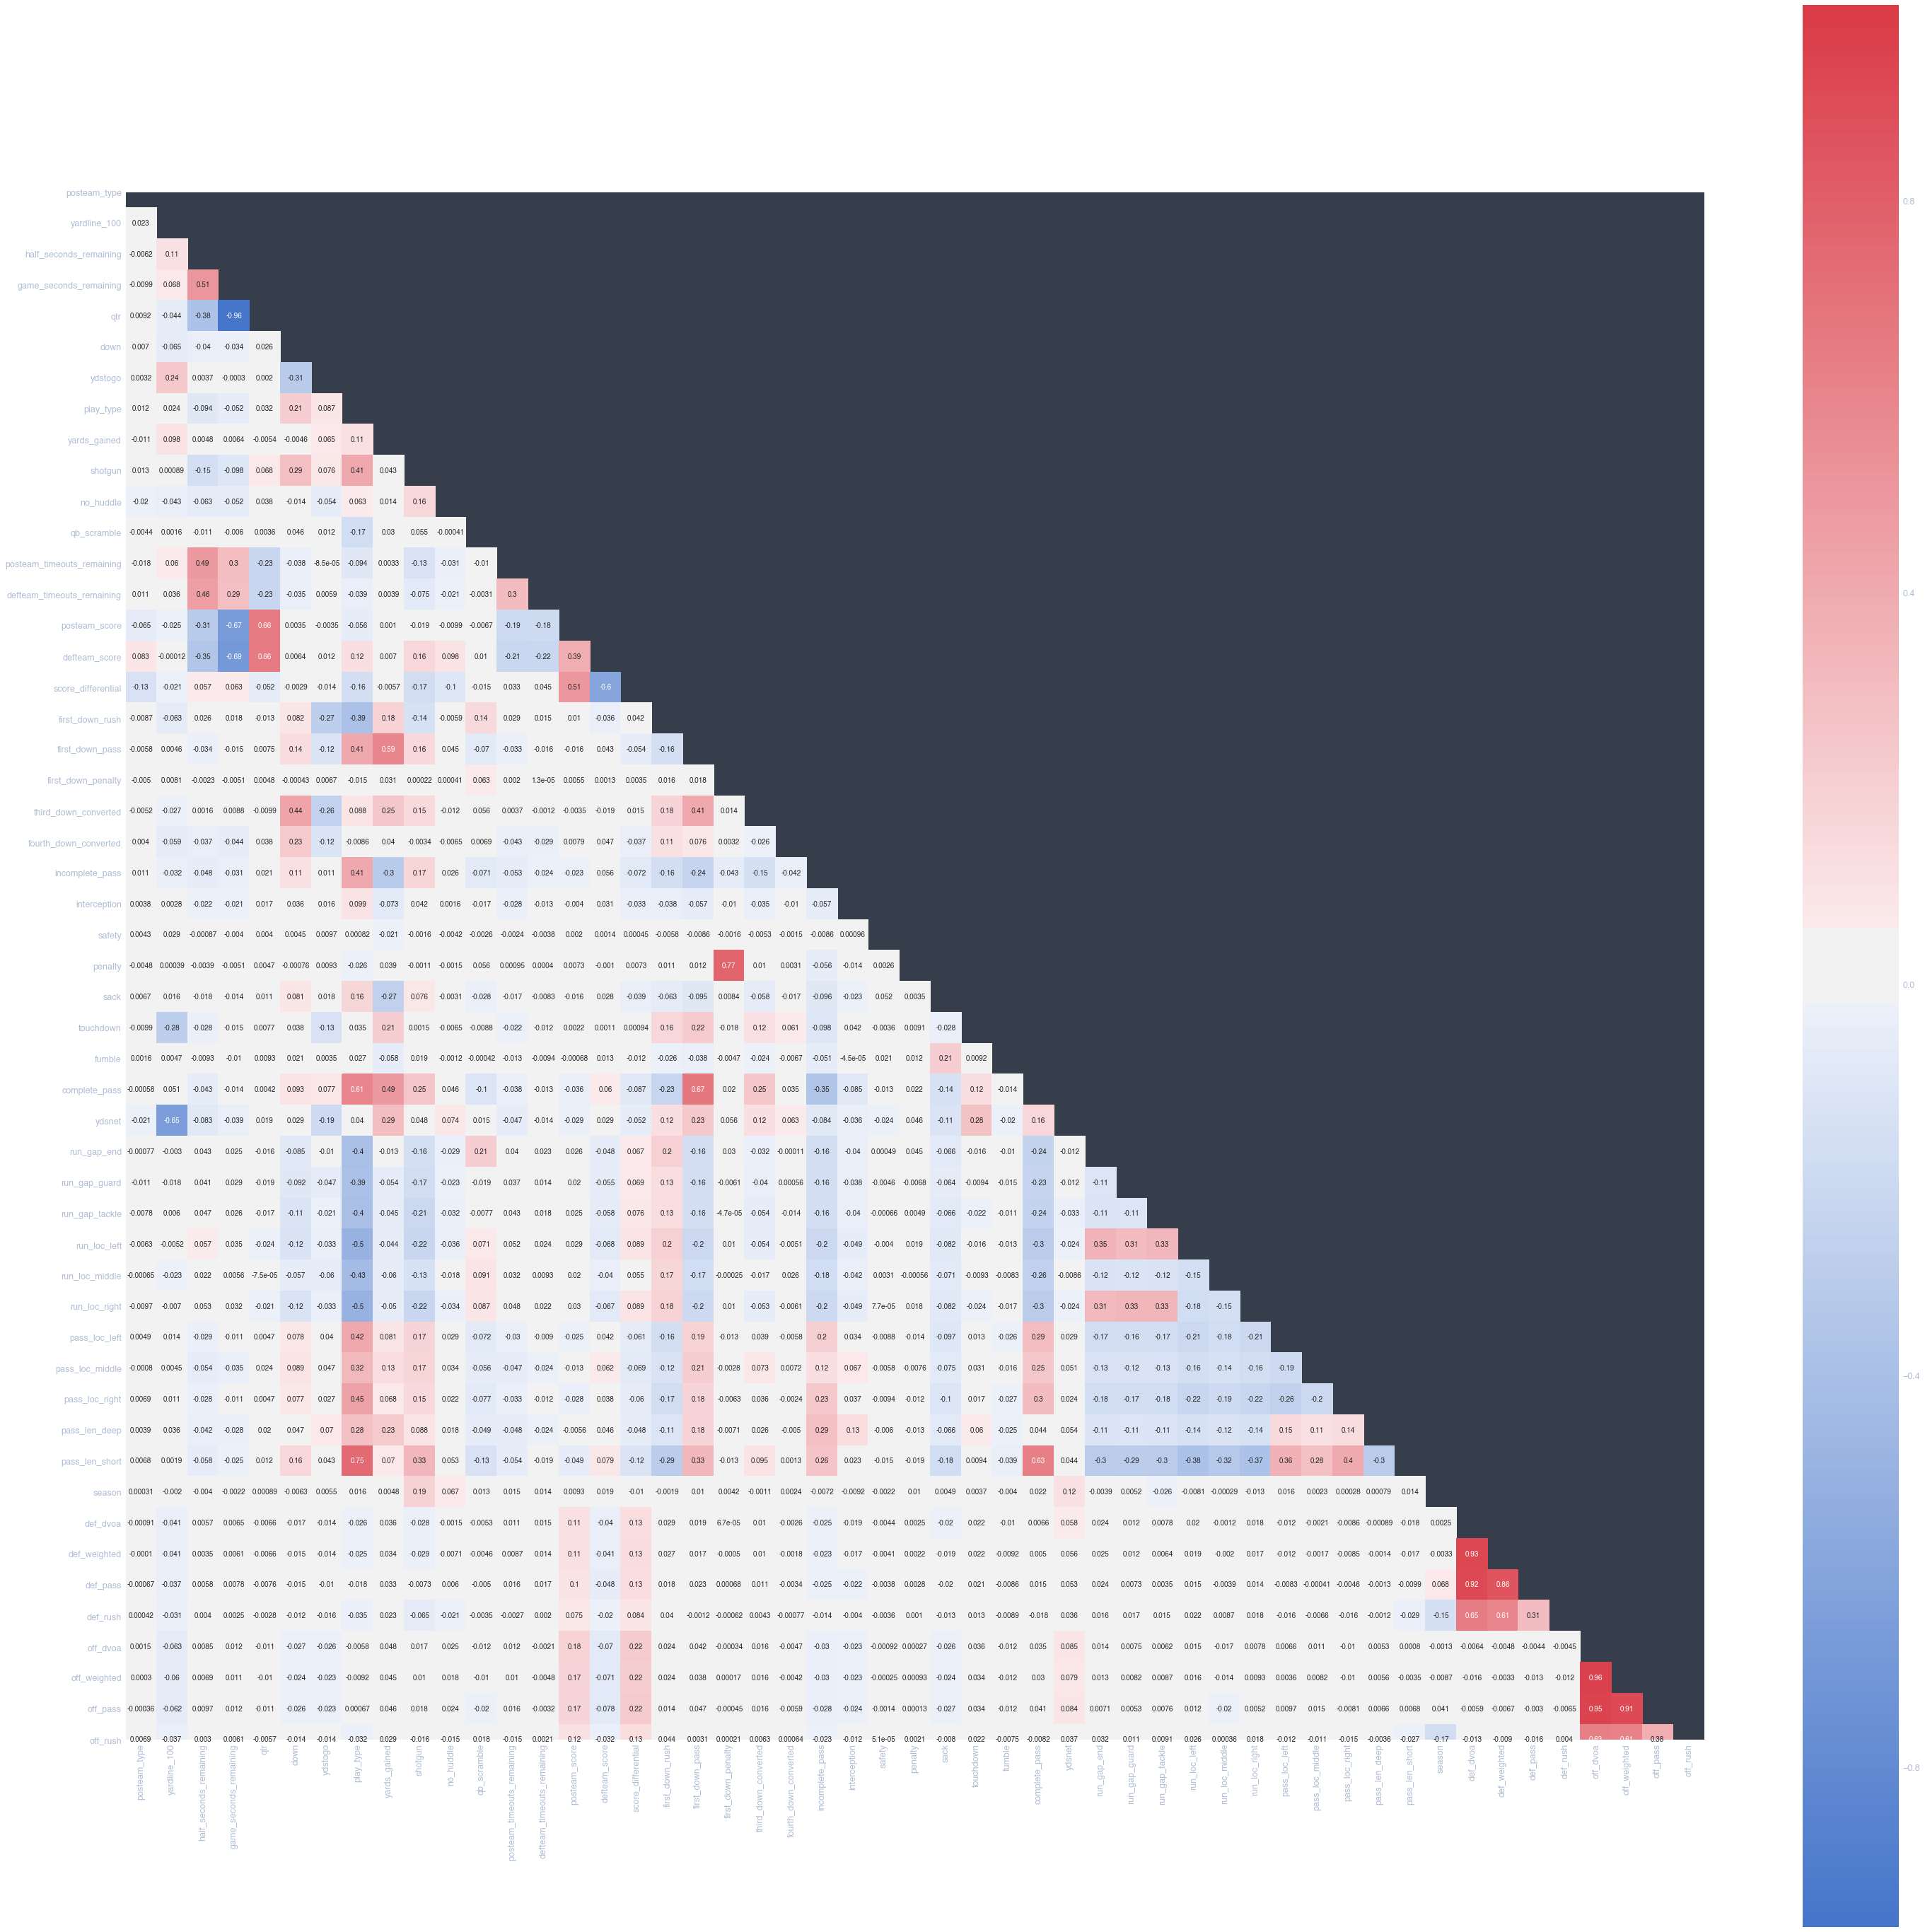

In [73]:
plt.figure(figsize = (50,50))
mask = np.zeros_like(df_rp.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(255, 10, as_cmap = True)
sns.heatmap(\
            df_rp.corr(), \
            annot = True, \
            square = True, \
            mask = mask, \
            cmap = cmap \
).get_figure().savefig("correlations_big_picture.png");

In [ ]:
sns.pairplot(df_rp, hue='play_type');

/Users/aleksandrbagdasarov/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/Users/aleksandrbagdasarov/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



KeyboardInterrupt: 